### 90803 Final Project

# Q3: Unsupervised Learning/Clustering for Cities

**Team 14**

Chi-Shiun Tsai & Colton Lapp

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn.decomposition import PCA

%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Set Seed

In [2]:
seed = 0

### Read in Data

In [3]:
#Set Base Dir
base_dir = os.getcwd().split('/')
base_dir = '/'.join(base_dir[0:-1])
base_dir
df = pd.read_csv(base_dir + '/Team14_CL_CT_MG/data/data_all.csv', low_memory=False)
df.head(3)

,Name,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,state,GEOID,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
0,"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.556830,6.763679,0.208245,3.913145,0.719466,36,3651000,8419316,-0.472295,777982727,434642000,5913.616647,220.640533
1,"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,1.007329,5.683670,19.986897,17.982834,12.855557,3.889962,1.788574,49.252959,4.056122,4.517605,33.341664,4.703748,4.288298,6.098239,2.086111,1.660996,1.278365,2.068393,7.988391,5.480588,3.824172,3.640193,5.838303,6.734288,0.256715,2.800433,0.887101,6,644000,3966936,0.159871,1214591312,87468461,6178.068445,67.066531
2,"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,1.200438,8.816058,20.245897,19.983537,12.676177,4.820647,1.800250,49.382610,12.919050,4.194570,23.775417,6.130186,4.004228,7.006176,1.199698,1.064406,2.110918,2.475895,5.359926,4.764597,5.445095,7.012289,6.614933,5.035996,0.455777,5.058372,0.868655,17,1714000,2709534,-0.375969,588881854,17621529,7499.869841,133.847542


## Set Up Data

### Adjust Row Names
Note: If we want to include state effects, we could keep that column and create boolean values out of oit

In [4]:
#Set row equal to name
df.set_index('Name', inplace=True, drop=True)

#Drop GEOID and STATE column
df = df.drop( ['GEOID', 'state'], axis=1)
df.head(1)

,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.55683,6.763679,0.208245,3.913145,0.719466,8419316,-0.472295,777982727,434642000,5913.616647,220.640533


## Final data cleaning

In [5]:
#Drop rows with infinite growth rates

starting_rows = df.shape[0]

# Find the indices of positive or negative infinity
inf_indices = np.isinf(df['Pop Chng %'])
# Drop rows
df = df[~inf_indices]


#Replace the missing value code from census data
df = df.replace(-666666666, np.nan)

#Forgot to normalize renter HH by population 
df['Renter Household'] = df['Renter Household']/df['Population 2020']

#Drop rows with NaN
df = df.dropna()

print("Went from {} rows to {} rows after cleaning".format(starting_rows, df.shape[0]))

Went from 19495 rows to 16665 rows after cleaning


# Data Transformations

### Take Log of skewed variables


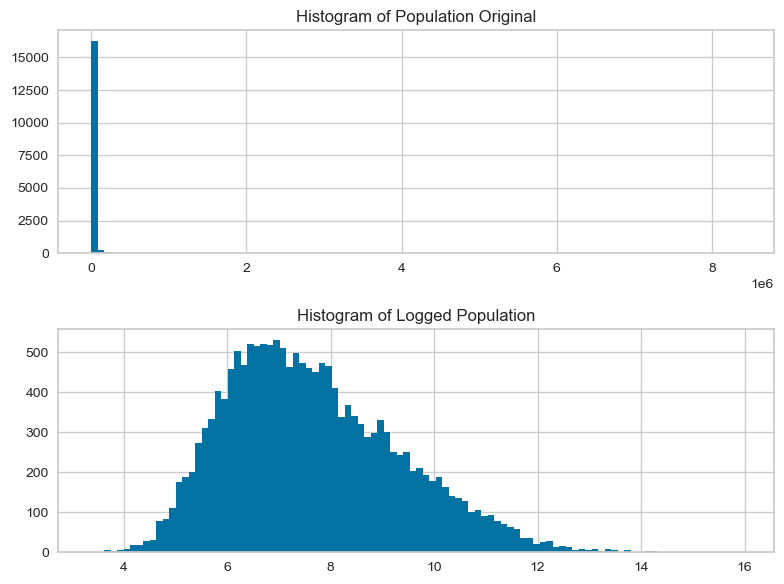

In [6]:
#Take Log of Population
df['Population 2020 Log'] = np.log(df['Population 2020'])


fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].hist( df['Population 2020'], bins=100)
axs[0].set_title('Histogram of Population Original')

axs[1].hist(df['Population 2020 Log'], bins=100)
axs[1].set_title('Histogram of Logged Population')

fig.tight_layout()
plt.show()

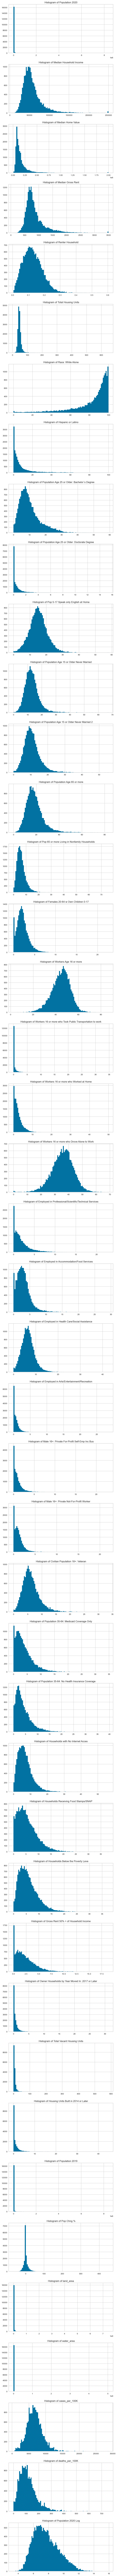

In [7]:
# Create a figure with subplots for each column
fig, axs = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(8, 4*len(df.columns)))

# Plot every 
for i, col in enumerate(df.columns):
    axs[i].hist(df[col], bins=100)
    axs[i].set_title(f'Histogram of {col}')
    
#Formatting
fig.tight_layout()
plt.show()

## Create X Dataset

In [8]:
#X = df.drop(['Population 2019'], axis=1)
X = df.drop(['Population 2020', 'Population 2019'], axis=1)

# Scale Data

In [9]:
#create a RobustScaler object
scaler = RobustScaler()

#Fit
scaler.fit(X)

#Transform X
X_RS = pd.DataFrame(  scaler.transform(X), columns = X.columns)
X_RS.set_index( X.index , drop=True, inplace=True)

X_RS.head()

,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K,Population 2020 Log
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",0.647260,5.096647,2.275862,1.635452,-0.305376,-2.530708,2.758687,0.997219,1.343578,-1.096272,0.903458,1.474518,-0.281360,-0.153786,-0.042021,0.152408,74.139766,0.676585,-2.553245,1.631022,0.322504,0.674214,0.819957,0.426612,0.818141,-1.168187,1.411508,0.052330,-0.199341,0.496800,0.309205,1.932001,-0.155182,-0.194989,0.313827,-0.101703,65.848890,2494.931064,-0.234153,1.472968,3.623932
"Los Angeles city, California",0.574755,5.446746,2.382445,1.231243,-0.647200,-2.135390,4.871871,1.027335,1.171674,-1.393215,1.318151,1.458334,-0.528429,-0.419518,-0.115254,0.379049,12.156743,1.099246,-0.268427,1.563989,0.627944,-0.067696,1.445180,0.888836,0.297351,-1.063775,1.307306,0.585054,-0.427727,-0.201049,0.157757,1.920325,-0.094837,-0.378486,0.449965,-0.008355,103.035288,502.017359,-0.141697,-0.430632,3.305946
"Chicago city, Illinois",0.442917,1.471400,1.225705,1.186947,-0.033152,-2.197749,2.725876,1.098528,1.453613,-0.923717,1.363339,1.832826,-0.549617,-0.192426,-0.108119,0.391180,38.720132,0.969437,-1.223167,2.225735,0.513316,0.190396,0.633870,0.356201,0.992553,-0.946590,0.613710,0.399274,-0.120881,0.451891,0.321452,1.245668,0.152995,-0.006130,0.434985,-0.087479,49.742976,101.068288,0.320419,0.397140,3.141208
"Houston city, Texas",0.092076,0.674556,1.012539,1.151612,-0.263412,-1.999697,4.475036,0.672988,1.345623,-1.039067,0.812543,0.933825,-0.749282,-0.493252,0.205911,0.232441,5.240494,0.465158,0.017546,1.277870,0.473067,-0.263867,0.201293,0.262019,0.146441,-0.800525,-0.106958,1.776834,-0.165890,0.138265,0.310617,1.314369,0.097172,-0.071325,1.864470,-0.014028,140.808836,466.309907,-0.556494,-0.547009,3.075429
"Phoenix city, Arizona",0.394071,1.305720,1.056426,0.418083,-0.672919,-1.131387,4.273558,0.456140,0.802561,-0.596011,0.708562,0.735016,-0.750629,-0.517081,0.362118,0.344294,3.973536,0.915630,-0.040566,1.046372,0.598014,-0.086834,0.382535,0.427782,0.253461,-0.388849,0.539544,0.825885,-0.405822,-0.081850,-0.062798,0.552467,0.465314,-0.381479,0.634583,0.197762,113.781749,18.493875,0.253047,0.177649,2.933617


# Model 1: K Means

### Step 1: Find optimal K

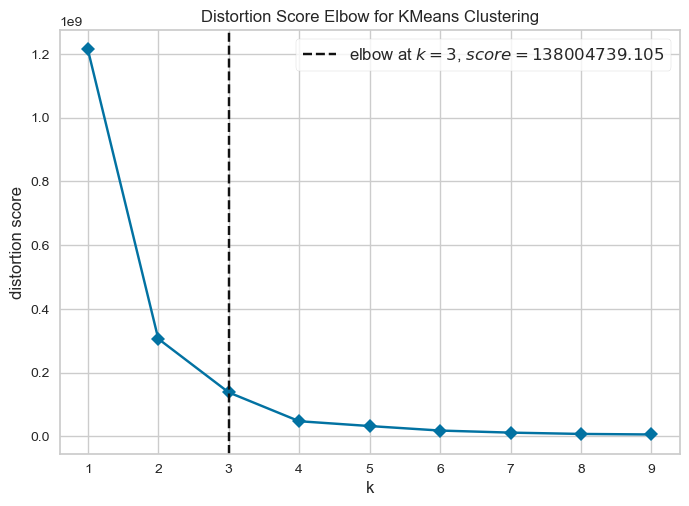

In [10]:
KM_baseline = KMeans(random_state=seed, n_init=10)
visualizer = KElbowVisualizer(KM_baseline,  k=(1,10), timings = False)
visualizer.fit(X_RS)
visualizer.show(); 

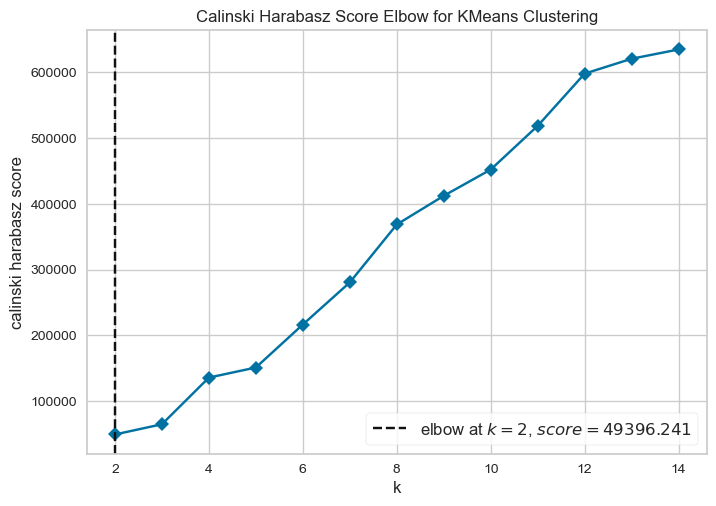

In [11]:
visualizer = KElbowVisualizer(KM_baseline, k=(2,15), metric='calinski_harabasz', timings=False, locate_elbow=True)
visualizer.fit(X_RS)
visualizer.show();

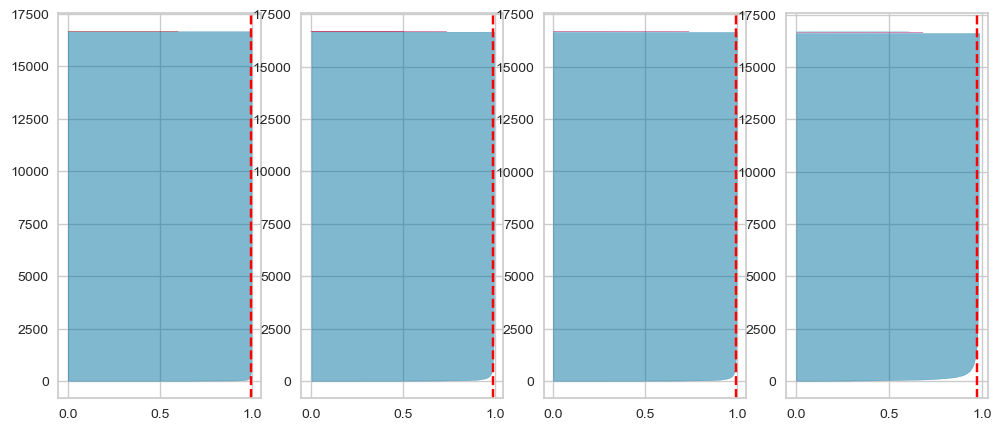

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(12,5))
j=0
h=0
for i in range(3,7):
    model = KMeans(random_state=seed, n_init=10, n_clusters=i)
    viz = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[i-3])
    viz.fit(X_RS)

# Graph our clusters using PCA

In [13]:
pca = PCA()
X_PCA = pd.DataFrame(pca.fit_transform(X_RS), index=X_RS.index)
X_PCA.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",2485.733026,-1.834201,69.363684,-1.122038,-17.000252,3.462265,3.280898,-4.228216,0.859549,2.481269,0.832664,-0.817886,0.522318,-0.604546,0.231400,-0.489283,0.150103,0.362488,-1.188145,-0.029818,-0.431013,-0.310653,0.574551,-0.635412,-0.322130,1.445794,0.256931,-0.306902,0.504191,-1.205407,0.531984,0.354815,-0.010051,-0.245809,-1.558401,-0.615722,-0.452076,-0.432333,-0.301113,0.046131,-0.049977
"Los Angeles city, California",494.623215,88.594613,6.700440,0.949380,-1.911118,0.520861,-2.072799,1.006248,-2.018139,0.088021,0.350818,-0.026519,1.609739,0.123901,-1.093177,-0.919717,-0.368228,0.470548,-0.948112,0.109855,1.012451,-0.026749,0.302355,-0.372290,0.281226,0.277257,0.474052,0.231031,0.471650,-0.195922,-0.052885,0.445845,-0.727202,0.279454,-0.090013,-0.120680,-0.458926,-0.293818,-0.230259,-0.027266,0.011670


## How much variance is PCA explaining

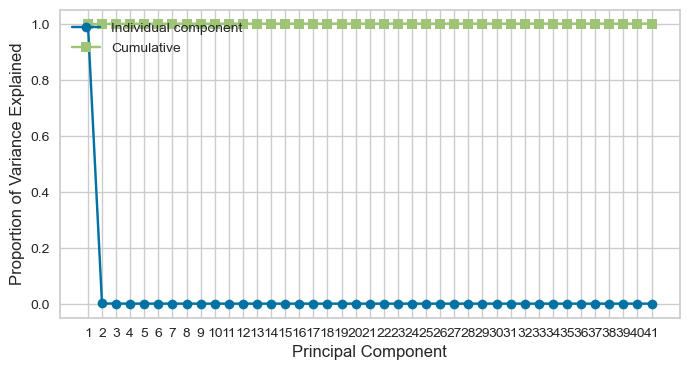

In [14]:
plt.figure(figsize=(8,4))

feats = range(1, len(pca.explained_variance_ratio_)+1,1)

plt.plot(feats, pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot(feats, np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(feats)
plt.legend(loc=2)
plt.show();

## Investigation: I think big cities are driving all our clustering

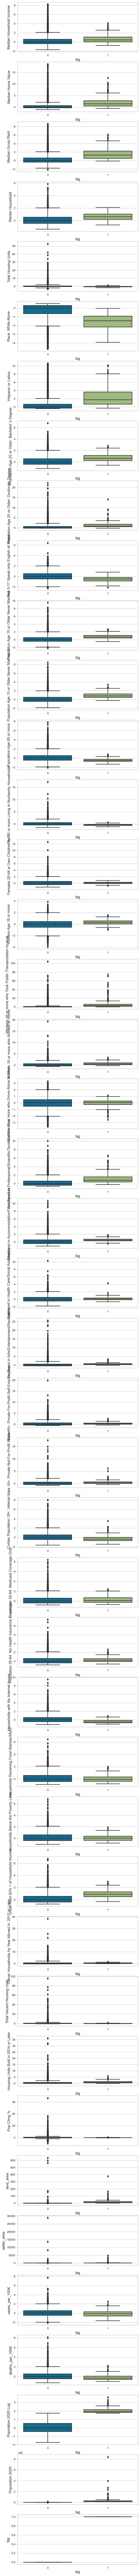

In [15]:
#Create "Big cities" boolean
#data_temp = df
data_temp = X_RS.join(df[['Population 2020']])
data_temp['big'] = (data_temp['Population 2020'] > 100000).astype(int)


cols = data_temp.columns.values
f, axes = plt.subplots(len(cols), 1, figsize=(7, 150))

for i in range(0, len(cols)):
    col = cols[i]
    sns.boxplot(  y=col, x= "big", data=data_temp,  orient='v' , ax=axes[i])

# References
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html 
- In class exercises week 12, 13, 14
- https://stackoverflow.com/questions/53310228/how-can-i-make-seaborn-distribution-subplots-in-a-loop